# Acceso a datos ERA5 en la nube

---

```{image} ../images/era-temp2.png
:width: 100%
:align: center
```

## Introducción

En este cuaderno aprenderás a acceder y analizar datos del reanálisis atmosférico **ERA5** utilizando **ArrayLake**, un servicio de repositorios Zarr en la nube que proporciona acceso eficiente a conjuntos de datos masivos.

ERA5 es la quinta generación de reanálisis producida por el ECMWF (Centro Europeo de Predicción Meteorológica a Mediano Plazo), que combina observaciones históricas con modelos numéricos para reconstruir el estado de la atmósfera desde 1950 hasta el presente. Este conjunto de datos es fundamental para estudios climáticos, análisis de eventos meteorológicos extremos, y validación de modelos.

Los datos que utilizaremos provienen del repositorio **`earthmover-public/era5-surface-aws`** en ArrayLake, que contiene **18 variables de superficie** para el período 1975-2024 (~30 TB) en formato **Zarr v3 / Icechunk**. Esta estructura permite acceso eficiente mediante dos estrategias de chunking optimizadas: una para análisis espaciales (mapas) y otra para series temporales.

## 📚 Descripción general

En este cuaderno aprenderás a:

1. Comprender qué es ERA5 y su importancia en estudios climáticos
2. Diferenciar entre grupos `spatial` y `temporal` optimizados para diferentes consultas
3. Acceder a datos ERA5 en formato Zarr v3 / Icechunk mediante ArrayLake
4. Realizar análisis espaciales eficientes (mapas globales y regionales)
5. Extraer y visualizar series temporales largas para ubicaciones específicas

## ✅ Requisitos previos

| Conceptos | Importancia | Notas |
| --- | --- | --- |
| [Introducción a Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Necesario | Manipulación de arreglos multidimensionales etiquetados |
| [Xarray: Agregación](https://foundations.projectpythia.org/core/xarray/computation-masking.html) | Necesario | Operaciones de agregación temporal y espacial |
| [Xarray: Lectura de datos](https://foundations.projectpythia.org/core/xarray/xarray-intro.html#opening-netcdf-data) | Necesario | Apertura de conjuntos de datos NetCDF/Zarr |
| [Fundamentos de Python](../1.fundamentos/1.1.Fundamentos-python.ipynb) | Necesario | Variables, funciones, estructuras de control |
| [Numpy](../1.fundamentos/1.2.Introduccion-Numpy.ipynb) | Útil | Operaciones con arreglos numéricos |
| Acceso a datos en la nube | Útil | Comprensión de formatos cloud-nativos (Zarr, Icechunk) |
| Conocimientos de meteorología | Útil | Interpretación de variables atmosféricas (temperatura, presión, viento) |

⏱️ **Tiempo estimado de aprendizaje**: 30 minutos  
✍️ Formato: Interactivo. Ejecuta y modifica el código en cada celda.

---

## Librerías

Importamos las bibliotecas necesarias para trabajar con ArrayLake y visualizar datos.

In [1]:
from arraylake import Client
import xarray as xr
import matplotlib.pyplot as plt

### Autenticación con ArrayLake

ArrayLake es un servicio de repositorios Zarr en la nube que proporciona acceso eficiente a grandes datasets como ERA5. Para usar ArrayLake:

1. **En Binder/JupyterHub**: Ejecuta `client.login()` y sigue las instrucciones para autenticarte
2. **En GitHub Actions**: Las credenciales se gestionan mediante secrets del repositorio

```{note}
ArrayLake almacena tu token en `~/.arraylake/token.json`. Solo necesitas autenticarte una vez por sesión.
```

In [2]:
client = Client()
client.login()  # Solo necesario la primera vez por sesión

🔓 Successfully refreshed tokens!

> Token stored at /home/alfonso/.arraylake/token.json

╭──────────────────────────────────────────────── 👤 User Details ────────────────────────────────────────────────╮
│ Name: Alfonso Ladino Rincon                                                                                     │
│ Email: alfonso8@illinois.edu                                                                                    │
│ Id: 07979de4-86d6-4a48-90fd-485ac4312916                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🔓 Successfully logged in!

> Token stored at /home/alfonso/.arraylake/token.json

╭──────────────────────────────────────────────── 👤 User Details ────────────────────────────────────────────────╮
│ Name: Alfonso Ladino Rincon                                                                                     │
│ Email: alfonso8@illinois.edu                                                                                    │
│ Id: 07979de4-86d6-4a48-90fd-485ac4312916                                                                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [3]:
repo = client.get_repo("earthmover-public/era5-surface-aws")

# Establecer vista de solo lectura del branch "main" inmutable
session = repo.readonly_session("main")

```{tip} Versionado de datos con Icechunk
:class: dropdown

**Icechunk** permite hacer seguimiento a los cambios realizados en el dataset mediante *snapshots*. Esto es similar a Git para código, pero diseñado específicamente para datos científicos masivos.

Puedes explorar el historial de cambios en la rama principal `main`:

```python
# Ver historial de snapshots
for snapshot in repo.ancestry(branch="main"):
    print(snapshot.message)
```

**Ventajas del versionado**:
- 📜 Trazabilidad completa de cambios en los datos
- 🔄 Posibilidad de revertir a versiones anteriores
- 🌳 Branching para experimentos paralelos
- 🔒 Reproducibilidad científica garantizada

Para este cuaderno, trabajamos con el snapshot inmutable de la rama `main`.
```

## 1. 🌍 Introducción a ERA5

ERA5 es la quinta generación de reanálisis atmosférico producida por el **Centro Europeo de Predicción Meteorológica a Mediano Plazo (ECMWF)**. Este conjunto de datos combina observaciones históricas con modelos numéricos para generar una reconstrucción coherente del estado de la atmósfera en el pasado reciente.

Los reanálisis son fundamentales para estudios climáticos, ya que proporcionan información espacial y temporalmente continua, incluso en regiones donde las observaciones directas son escasas.

### 1.1. 📌 ¿Qué es un Reanálisis?

Un **reanálisis** es una reconstrucción científica del clima pasado basada en:

- 🌐 **Observaciones históricas**:
  - Estaciones de superficie
  - Globos meteorológicos
  - Satélites
  - Buques, boyas y aviones

- 🧠 **Modelos numéricos**:
  - Ecuaciones físicas modernas de la atmósfera
  - Técnicas de asimilación de datos
  - Poder computacional avanzado

### 1.2. 📎 Características clave de ERA5

- ✅ Cobertura global: datos para toda la Tierra
- ⏱️ Periodo temporal: desde 1950 hasta el presente (con datos horarios desde 1979)
- 🌐 Resolución espacial: 0.25° (~31 km)
- 📈 Más de 240 variables disponibles (temperatura, viento, precipitación, etc.)
- ⚙️ Datos consistentes gracias a la asimilación de observaciones

💡 **Nota:** En este cuaderno trabajaremos directamente con los datos de ERA5 almacenados en formato Zarr en Google Cloud, lo que permite explorar grandes volúmenes de información sin necesidad de descargarlos completamente.


## 2. ☁️ Acceso a datos ERA5 con ArrayLake

El conjunto de datos ERA5 está disponible a través de **ArrayLake** en el repositorio `earthmover-public/era5-surface-aws`. Esta versión curada contiene:

- ✅ **18 variables de superficie** (temperatura 2m, viento 10m, presión, nubosidad, etc.)
- 📅 **Periodo**: 1975-01-01 a 2024-12-31 (50 años de datos horarios)
- 🌐 **Resolución espacial**: 0.25° (~31 km)
- ⏱️ **Resolución temporal**: Horaria
- 💾 **Tamaño total**: ~30 TB en formato Zarr v3 / Icechunk

### Grupos de datos

El repositorio ofrece dos grupos con diferentes estrategias de chunking:

1. **`spatial`**: Optimizado para consultas espaciales (mapas globales)
   - Chunks: `(time=1, latitude=721, longitude=1440)`
   - Ideal para: Visualizar campos instantáneos, análisis de patrones espaciales

2. **`temporal`**: Optimizado para series temporales y ML
   - Chunks: `(time=8736, latitude=12, longitude=12)` → 1 año de datos horarios
   - Ideal para: Series temporales, entrenamiento de modelos ML/IA

## 3. 🗺️ Grupo Spatial - Análisis espacial

Comenzamos trabajando con el grupo **`spatial`**, optimizado para consultas de mapas y análisis espaciales.

Este grupo usa chunks `(time=1, latitude=721, longitude=1440)` que cargan **un mapa completo** por cada paso temporal.

### 3.1. 🔓 Apertura del grupo spatial

In [4]:
%%time
ds_spatial = xr.open_dataset(
    session.store,
    engine="zarr",
    consolidated=False,
    zarr_format=3,
    chunks={},
    group="spatial"  # Grupo optimizado para consultas espaciales
)

CPU times: user 1.84 s, sys: 126 ms, total: 1.97 s
Wall time: 2.58 s


El conjunto de datos se ha abierto correctamente utilizando acceso anónimo y carga perezosa (lazy loading) gracias al formato `zarr`

In [5]:
display(ds_spatial)

<xarray.Dataset> Size: 40TB
Dimensions:    (time: 438312, latitude: 721, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 4MB 1975-01-01 ... 2024-12-31T23:00:00
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Data variables: (12/22)
    cape       (time, latitude, longitude) float32 2TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    sd         (time, latitude, longitude) float32 2TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    d2         (time, latitude, longitude) float32 2TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    skt        (time, latitude, longitude) float32 2TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    cp         (latitude, longitude, time) float32 2TB dask.array<chunksize=(721, 1440, 72), meta=np.ndarray>
    lsp        (latitude, longitude, time) float32 2TB dask.array<chunksize=(721, 1440, 72), meta=np.ndarray>
    ...         ...
    tcw        (time, latitude, longitude) float32 2TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    tcc        (time, latitude, longitude) float32 2TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 2TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    u100       (time, latitude, longitude) float32 2TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 2TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
    v100       (time, latitude, longitude) float32 2TB dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>
Attributes:
    DATA_SOURCE:  ECMWF: https://cds.climate.copernicus.eu, Copernicus Climat...
    Conventions:  CF-1.6
    history:      Created by Earthmover PBC on 2025-09-06 21:03:36 by combini...

### 3.2. 📋 Contenido del conjunto de datos

El conjunto de datos contiene:

- ➕ **18 variables de superficie horarias** (e.g., `t2`, `d2`, `u10`, `v10`, `sp`, `cape`)
- 📐 **Dimensiones**: time (438,312) × latitude (721) × longitude (1,440)
- 🌍 **Coordenadas**: latitudes −90° → 90°, longitudes 0° → 360°
- 💾 **Tamaño total**: ~30 TB almacenados en formato Zarr v3 / Icechunk
- 📝 **Metadatos globales**: CF-1.6, fuente de datos, historial

### 3.3. 💾 Tamaño del conjunto de datos

Una vez abierto el conjunto de datos, es útil calcular su tamaño total estimado en memoria. Esto nos ayuda a dimensionar los recursos necesarios para su análisis.

In [6]:
# Tamaño total del dataset en TB (terabytes)
size_tb = ds_spatial.nbytes / 1024**4
print(f"Dataset size: {size_tb:.1f} TB")

Dataset size: 36.4 TB


```{note}
El conjunto de datos `spatial` contiene ~36 TB de datos. Gracias al formato Zarr y la estrategia de chunking, solo se cargan los bloques necesarios para cada operación.
```

---

### 3.4. 🌍 Visualización: Mapa global

Visualicemos la temperatura global en un instante específico. Gracias al chunking espacial, cargar un mapa completo es muy eficiente.

In [7]:
# Extraer la variable de temperatura a 2 metros
t2m = ds_spatial.t2

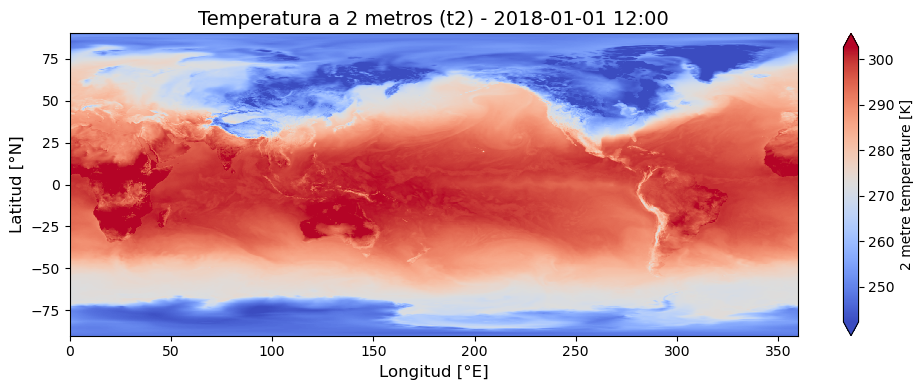

In [8]:
import matplotlib.pyplot as plt

# Seleccionar un instante específico
instant = "2018-01-01 12:00"
fig, ax = plt.subplots(figsize=(10, 4))

# Graficar temperatura en Kelvin
t2m.sel(time=instant).plot(ax=ax, cmap="coolwarm", robust=True)

# Embellecer la figura
ax.set_title(f"Temperatura a 2 metros (t2) - {instant}", fontsize=14)
ax.set_xlabel("Longitud [°E]", fontsize=12)
ax.set_ylabel("Latitud [°N]", fontsize=12)
ax.tick_params(labelsize=10)

plt.tight_layout()
plt.savefig("../images/era-temp2.png", dpi=150, bbox_inches="tight")
plt.show()

```{note}
La visualización accede únicamente a los datos del tiempo y la región seleccionados. Esta eficiencia se logra gracias a la combinación de `xarray`, `Zarr` y `Dask` (si está disponible).
```

### 3.5. 🇨🇴 Subsetting espacial: Colombia

Ahora aprendamos a seleccionar una **subregión espacial**. Vamos a extraer datos solo para Colombia y visualizar la temperatura promedio para un día específico.

En ERA5, las longitudes van de 0° a 360° (en lugar de -180° a 180°). Para Colombia usamos:
- **Longitud**: 275° a 300° (equivalente a -85° a -60°)
- **Latitud**: 14° a -3°

In [9]:
# Seleccionar región de Colombia usando el grupo spatial
t2_colombia = ds_spatial.t2.sel(
    longitude=slice(275, 300),  # -85° a -60°
    latitude=slice(14, -3),     # Norte a sur
    time="2024-06-14"           # Un día específico
)

# Convertir a Celsius y promediar el día
t2_colombia_mean = (t2_colombia - 273.15).mean(dim="time")

print(f"Shape: {t2_colombia_mean.shape}")  # (69, 101) - región de Colombia

Shape: (69, 101)


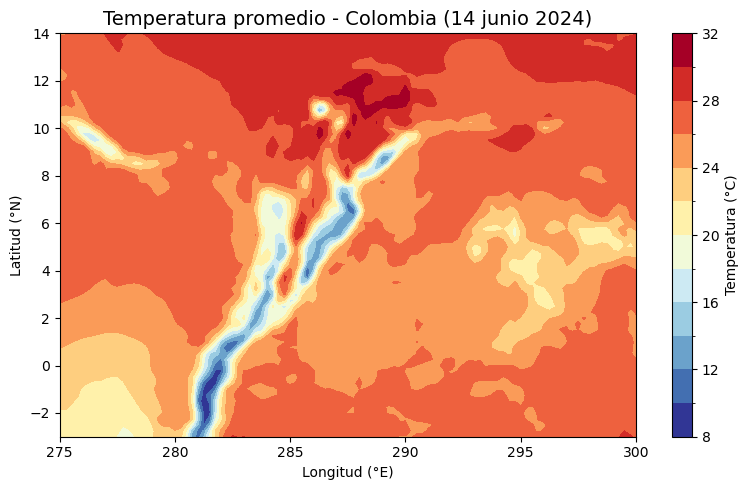

In [21]:
# Visualizar temperatura promedio diaria sobre Colombia
fig, ax = plt.subplots(figsize=(8, 5))
t2_colombia_mean.plot.contourf(
    ax=ax,
    cmap="RdYlBu_r",
    levels=15,
    cbar_kwargs={"label": "Temperatura (°C)"}
)
ax.set_title("Temperatura promedio - Colombia (14 junio 2024)", fontsize=14)
ax.set_xlabel("Longitud (°E)")
ax.set_ylabel("Latitud (°N)")
plt.tight_layout()
plt.show()

```{note}
**Lazy loading en acción**: Xarray solo cargó los datos necesarios para Colombia (69×101 puntos × 24 horas = ~670 KB), no los 30 TB completos del dataset.
```

---

### ✏️ Ejercicio 1: Practica subsetting espacial

**Objetivo**: Aplicar lo aprendido sobre selección espacial con el grupo `spatial`.

**Tareas**:
1. Extrae un mapa de presión superficial (`sp`) para **15 de agosto de 2024 a las 12:00 UTC**
2. Selecciona la región de la **Amazonía** (lon=[280:300], lat=[5:-10]) para **1 de enero de 2024**
3. Calcula y visualiza la temperatura promedio de ese día sobre la Amazonía

In [11]:
# Tu código aquí

````{admonition} Solución
:class: dropdown

```python
# 1. Mapa de presión superficial
sp_map = ds_spatial.sp.sel(time="2024-08-15 12:00")
sp_map.plot(cmap="viridis", figsize=(10, 5))
plt.title("Presión superficial - 15 agosto 2024 12:00 UTC")
plt.show()

# 2. Región Amazonía para un día
t2_amazon = ds_spatial.t2.sel(
    time="2024-01-01",
    longitude=slice(280, 300),
    latitude=slice(5, -10)
)

# 3. Temperatura promedio del día
t2_amazon_mean = (t2_amazon - 273.15).mean(dim="time")
t2_amazon_mean.plot.contourf(cmap="RdYlBu_r", figsize=(8, 6))
plt.title("Temperatura promedio - Amazonía (1 enero 2024)")
plt.xlabel("Longitud (°E)")
plt.ylabel("Latitud (°N)")
plt.show()
```

**Nota**: El grupo `spatial` es ideal para estos casos porque carga mapas completos eficientemente.
````

---

## 4. ⏱️ Grupo Temporal - Series de tiempo

Ahora trabajamos con el grupo **`temporal`**, optimizado para series temporales largas.

Este grupo usa chunks `(time=8736, latitude=12, longitude=12)` que cargan **1 año completo** de datos para ubicaciones pequeñas.

### 4.1. 🔓 Apertura del grupo temporal

In [12]:
%%time
ds_temporal = xr.open_dataset(
    session.store,
    engine="zarr",
    consolidated=False,
    zarr_format=3,
    chunks={},
    group="temporal"  # Grupo optimizado para series temporales
)

CPU times: user 47.4 ms, sys: 9.24 ms, total: 56.7 ms
Wall time: 588 ms


```{note}
Ambos grupos (`spatial` y `temporal`) contienen los mismos datos (18 variables, 1975-2024), pero con diferentes estrategias de chunking optimizadas para distintos tipos de análisis.
```

```{admonition} 🎯 Comparación: ¿Cuándo usar cada grupo?
:class: tip

| Caso de uso | Grupo recomendado | Razón |
|------------|-------------------|-------|
| Mapa global en un instante | `spatial` | Un chunk = un mapa completo |
| Región espacial (ej: Colombia) en período corto | `spatial` | Chunks contiguos en espacio |
| Serie temporal larga en un punto | `temporal` | Un chunk = 1 año de datos |
| Múltiples puntos para ML/forecasting | `temporal` | Carga eficiente de historiales |
| Climatología espacial (promedios) | `spatial` | Agrega sobre tiempo con mapas |
| Climatología temporal (tendencias) | `temporal` | Agrega sobre espacio con series |

**Regla general**: Si tu análisis enfatiza **espacio**, usa `spatial`. Si enfatiza **tiempo**, usa `temporal`.
```

---

### 4.2. 📈 Serie temporal para Bogotá

Extraigamos una serie temporal completa para Bogotá usando el grupo `temporal`. Este tipo de consulta ("churro") es exactamente para lo que este grupo fue optimizado.

```{tip}
**Cuándo usar cada grupo:**
- 🗺️ **Spatial**: Mapas, análisis espaciales, regiones grandes en tiempos específicos
- 📈 **Temporal**: Series temporales, análisis de tendencias, ML/forecasting en ubicaciones específicas
```

### Extracción de serie temporal para Bogotá

Bogotá está ubicada aproximadamente en:
- Latitud: 4.7° N
- Longitud: 285.9° E (equivalente a -74.1° W)

Extraigamos la temperatura para todo el año 2024:

In [13]:
# Extraer serie temporal para Bogotá usando el grupo temporal
t2_bogota_2024 = ds_temporal.t2.sel(
    time=slice("2024-01-01", "2024-12-31")).sel(
    latitude=4.7,
    longitude=285.9,
    method='nearest'  # Encuentra el punto más cercano
)

# Convertir a Celsius
t2_bogota_celsius = t2_bogota_2024 - 273.15

print(f"Shape: {t2_bogota_celsius.shape}")  # (8784,) = 366 días × 24 horas (2024 es bisiesto)
print(f"Temperatura promedio 2024: {t2_bogota_celsius.mean().values:.2f} °C")

Shape: (8784,)
Temperatura promedio 2024: 13.85 °C


### Visualización de la serie temporal

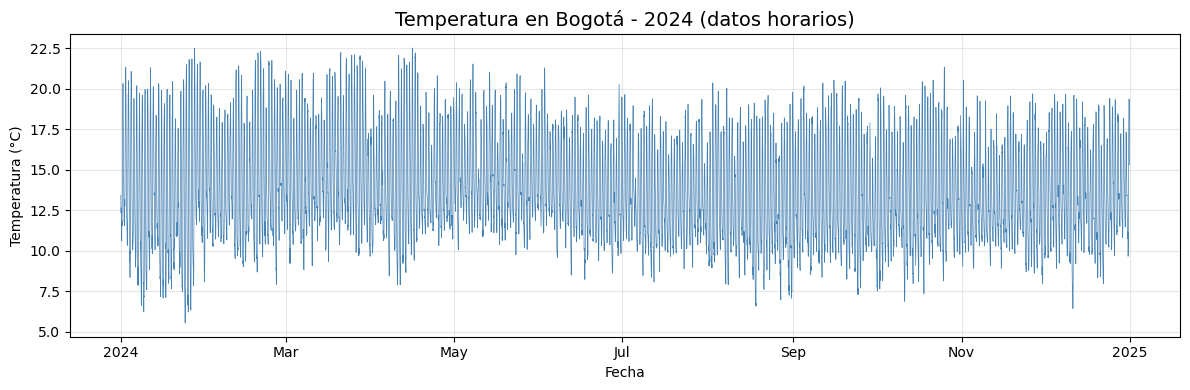

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 4))

# Graficar serie completa
t2_bogota_celsius.plot(ax=ax, linewidth=0.5, color="steelblue")

ax.set_title("Temperatura en Bogotá - 2024 (datos horarios)", fontsize=14)
ax.set_xlabel("Fecha")
ax.set_ylabel("Temperatura (°C)")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

```{note}
El grupo `temporal` carga eficientemente esta serie de ~8700 puntos porque los chunks contienen años completos para ubicaciones pequeñas. Con el grupo `spatial`, esta consulta requeriría acceder a ~8700 chunks diferentes (uno por hora).
```

### Cálculo de climatología mensual

Podemos calcular promedios mensuales usando `.groupby()`:

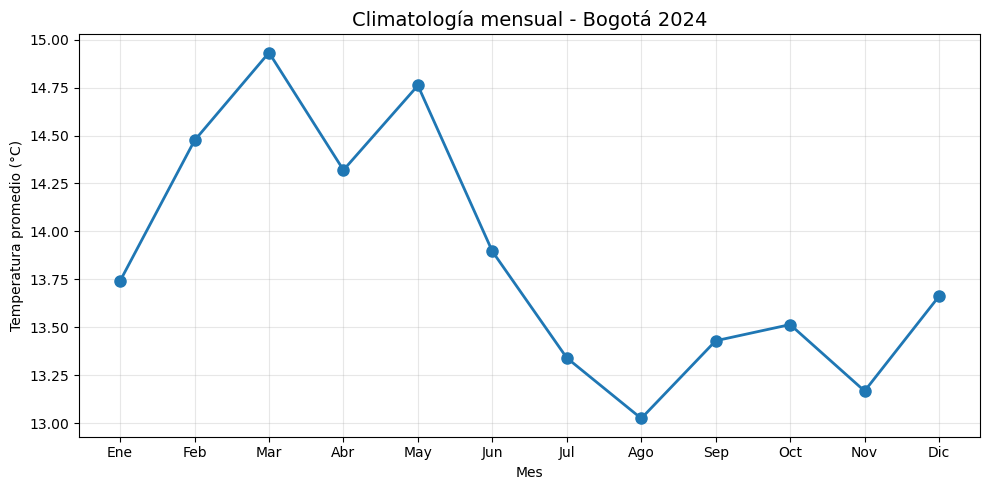

In [15]:
# Climatología mensual para Bogotá
t2_bogota_monthly = t2_bogota_celsius.groupby("time.month").mean()

# Visualizar
fig, ax = plt.subplots(figsize=(10, 5))
t2_bogota_monthly.plot(ax=ax, marker="o", linewidth=2, markersize=8)
ax.set_title("Climatología mensual - Bogotá 2024", fontsize=14)
ax.set_xlabel("Mes")
ax.set_ylabel("Temperatura promedio (°C)")
ax.set_xticks(range(1, 13))
ax.set_xticklabels(["Ene", "Feb", "Mar", "Abr", "May", "Jun", 
                    "Jul", "Ago", "Sep", "Oct", "Nov", "Dic"])
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

```{tip}
**Ventaja del grupo temporal para ML/IA:**

Este chunking es ideal para entrenar modelos de predicción meteorológica porque:
- Carga rápida de historiales largos (años) para múltiples ubicaciones
- Minimiza operaciones de I/O al tener datos contiguos en el tiempo
- Facilita feature engineering con ventanas temporales
```

```{hint}
Este paso activa la lectura de datos desde el repositorio remoto (data streaming). Solo se traen los bloques necesarios para completar esta visualización específica.
```

---

### ✏️ Ejercicio 2: Practica series temporales

**Objetivo**: Extraer y analizar series temporales con el grupo `temporal`.

**Tareas**:
1. Extrae la serie de viento zonal (`u10`) para **Medellín** (lat=6.25, lon=284.5) durante **enero 2024**
2. Calcula el viento promedio y grafícalo
3. Compara la temperatura de **Bogotá** vs **Barranquilla** (lat=11.0, lon=285.2) para la **primera semana de enero 2024**

In [16]:
# Tu código aquí

````{admonition} Solución
:class: dropdown

```python
# 1. Viento zonal Medellín (enero 2024)
u10_medellin = ds_temporal.u10.sel(
    time=slice("2024-01-01", "2024-01-31"),
    latitude=6.25,
    longitude=284.5,
    method="nearest"
)

# 2. Calcular promedio y graficar
print(f"Viento promedio: {u10_medellin.mean().values:.2f} m/s")
u10_medellin.plot(figsize=(12, 4))
plt.title("Viento zonal (u10) - Medellín (enero 2024)")
plt.ylabel("Velocidad (m/s)")
plt.grid(True, alpha=0.3)
plt.show()

# 3. Comparar Bogotá vs Barranquilla
fig, ax = plt.subplots(figsize=(12, 5))

t2_bogota = ds_temporal.t2.sel(
    time=slice("2024-01-01", "2024-01-07"),
    latitude=4.7, longitude=285.9, method="nearest"
) - 273.15

t2_barranquilla = ds_temporal.t2.sel(
    time=slice("2024-01-01", "2024-01-07"),
    latitude=11.0, longitude=285.2, method="nearest"
) - 273.15

t2_bogota.plot(ax=ax, label="Bogotá", linewidth=1.5)
t2_barranquilla.plot(ax=ax, label="Barranquilla", linewidth=1.5)
ax.legend()
ax.set_title("Temperatura - Bogotá vs Barranquilla (primera semana enero 2024)")
ax.set_ylabel("Temperatura (°C)")
ax.grid(True, alpha=0.3)
plt.show()
```

**Nota**: El grupo `temporal` carga eficientemente series largas para ubicaciones puntuales.
````

---

## 5. ¿Qué sigue?

Ahora que sabes cómo acceder a datos ERA5 en formato Zarr, puedes explorar:

- **[ENSO y temperatura superficial del mar](3.1.ENSO.ipynb)** - Analiza la relación entre ERA5 y eventos El Niño/La Niña
- **[Temperatura global media con CMIP6](3.2.Global-Mean-SST.ipynb)** - Compara proyecciones climáticas con reanálisis
- **[Perfiles Cuasi-Verticales con radar](3.4.QVPs.ipynb)** - Combina datos de radar con ERA5 para validación

### Proyecto sugerido

Desarrolla un análisis de tendencias climáticas para Colombia:

1. Extrae temperatura mensual para Colombia desde 1979 hasta el presente
2. Calcula la tendencia lineal y estadísticas de cambio
3. Visualiza la serie temporal con anomalías respecto a la climatología 1991-2020
4. Compara con datos de estaciones del IDEAM para validación

Este proyecto te introducirá al análisis de variabilidad y cambio climático regional usando reanálisis.

## 6. ✅ Conclusiones

En este cuadernillo aprendimos a acceder y explorar el conjunto de datos de reanálisis **ERA5** a través de **ArrayLake**, utilizando el repositorio `earthmover-public/era5-surface-aws`. Algunos puntos clave:

✔️ Comprendimos qué es un reanálisis y por qué ERA5 es fundamental para estudios climáticos
✔️ Accedimos al dataset (18 variables, 30 TB, 1975-2024) sin descarga local usando ArrayLake
✔️ Exploramos dos grupos optimizados: `spatial` (mapas) y `temporal` (series de tiempo)
✔️ Realizamos selección espacial sobre Colombia y visualizamos campos de temperatura
✔️ Aplicamos principios de *lazy loading* y *data streaming* con Zarr v3 / Icechunk
✔️ Comprendimos la importancia del chunking para optimizar diferentes tipos de consultas

## 📚 Recursos y referencias

- [ERA5 en ECMWF](https://www.ecmwf.int/en/forecasts/datasets/reanalysis-datasets/era5)
- [ArrayLake ERA5-Surface](https://app.earthmover.io/earthmover-public/era5-surface-aws)
- [NSF NCAR Curated ERA5](https://aws.amazon.com/marketplace/pp/prodview-yp5xkpkx2nfro)
- [Zarr v3 documentation](https://zarr.readthedocs.io/en/stable/)
- [Icechunk documentation](https://icechunk.io/)
- [xarray documentation](https://docs.xarray.dev/en/stable/)
- [Project Pythia Foundations](https://foundations.projectpythia.org/)

---

## 7. ✏️ Ejercicios adicionales

Ahora que has practicado análisis espacial y series temporales, aquí tienes ejercicios adicionales para profundizar tus habilidades.

In [17]:
# Tu código aquí

````{admonition} Solución
:class: dropdown

```python
# 1. Listar todas las variables
print(list(ds_spatial.data_vars))

# 2. Inspeccionar atributos de presión superficial
print(ds_spatial.sp.attrs)

# 3. Verificar dimensiones y tamaño de u10
print(f"Dimensiones: {ds_spatial.u10.dims}")
print(f"Shape: {ds_spatial.u10.shape}")
print(f"Tamaño: {ds_spatial.u10.nbytes / 1024**4:.2f} TB")
```
````

---

### Ejercicio 4: Selección espacial con grupo `spatial`

**Objetivo**: Practicar subsetting espacial eficiente para análisis de mapas.

**Tarea**: Usando el grupo `spatial` (optimizado para consultas espaciales):
1. Extrae un mapa de presión superficial (`sp`) para el 15 de agosto de 2024 a las 12:00 UTC
2. Selecciona la región de Colombia (lon=[275:300], lat=[14:-3]) para todo el mes de junio 2024
3. Calcula la temperatura promedio para la Amazonía (lon=[280:300], lat=[-10:5]) el 1 de enero de 2024

In [18]:
# Tu código aquí

````{admonition} Solución
:class: dropdown

```python
# 1. Mapa de presión (snapshot temporal, análisis espacial completo)
sp_map = ds_spatial.sp.sel(time="2024-08-15 12:00")
print(f"Shape: {sp_map.shape}")  # (721, 1440) - mapa global

# Visualizar
sp_map.plot(cmap="viridis")
plt.title("Presión superficial - 15 agosto 2024 12:00 UTC")

# 2. Región Colombia - mes completo (análisis espaciotemporal)
colombia_jun = ds_spatial.t2.sel(
    time=slice("2024-06-01", "2024-06-30"),
    longitude=slice(275, 300),
    latitude=slice(14, -3)
)
print(f"Shape: {colombia_jun.shape}")  # (720, 69, 101) = 30 días × 24 horas

# 3. Promedio Amazonía para un día
amazon_mean = ds_spatial.t2.sel(
    time="2024-01-01",
    longitude=slice(280, 300),
    latitude=slice(5, -10)
).mean(dim=["time", "latitude", "longitude"])
print(f"Temp promedio Amazonía: {amazon_mean.values - 273.15:.2f} °C")
```

**¿Por qué usar spatial?** Estas consultas requieren datos de múltiples ubicaciones espaciales en tiempos específicos. El chunking `(time=1, lat=721, lon=1440)` carga mapas completos eficientemente.
````

---

### Ejercicio 5: Cálculos estadísticos

**Objetivo**: Aplicar operaciones estadísticas sobre dimensiones específicas.

**Tarea**:
1. Calcula la temperatura promedio global para el año 2020
2. Encuentra la presión superficial (`sp`) máxima y mínima para Colombia (lat=[14:-3], lon=[275:300]) durante 2024
3. Calcula la climatología mensual de temperatura (promedio por mes) para el período 2015-2024

In [19]:
# Tu código aquí

````{admonition} Solución
:class: dropdown

```python
# 1. Temperatura promedio global 2020
t2_2020 = ds_spatial.t2.sel(time=slice("2020-01-01", "2020-12-31"))
t2_global_mean = t2_2020.mean(dim=["time", "latitude", "longitude"])
print(f"Temperatura global 2020: {t2_global_mean.values - 273.15:.2f} °C")

# 2. Presión máxima/mínima para Colombia en 2024
sp_col_2024 = ds_spatial.sp.sel(
    time=slice("2024-01-01", "2024-12-31"),
    longitude=slice(275, 300),
    latitude=slice(14, -3)
)
print(f"Presión máxima: {sp_col_2024.max().values / 100:.2f} hPa")
print(f"Presión mínima: {sp_col_2024.min().values / 100:.2f} hPa")

# 3. Climatología mensual 2015-2024
t2_period = ds_spatial.t2.sel(time=slice("2015-01-01", "2024-12-31"))
t2_monthly = t2_period.groupby("time.month").mean()
print(t2_monthly)

# Visualizar
(t2_monthly.mean(dim=["latitude", "longitude"]) - 273.15).plot()
plt.title("Climatología mensual global 2015-2024")
plt.ylabel("Temperatura (°C)")
plt.xlabel("Mes")
```
````

---

### Ejercicio 6: Series temporales con grupo `temporal`

**Objetivo**: Extraer series temporales largas para ubicaciones específicas (churros).

**Tarea**: Usando el grupo `temporal` (optimizado para series de tiempo):
1. Extrae la serie temporal de viento zonal (`u10`) para Medellín (lat=6.25, lon=284.5) durante 2023-2024
2. Calcula la velocidad promedio del viento para Cali (lat=3.4, lon=283.5) por mes en 2024
3. Compara las series de temperatura para 3 ciudades: Bogotá (4.7, 285.9), Barranquilla (11, 285.2), Pasto (1.2, 282.9) en enero 2024
4. Identifica el día más cálido del año 2024 en Cartagena (lat=10.4, lon=284.5)

```{tip}
Usa `.groupby("time.month")` para promedios mensuales y `.argmax()` para encontrar el índice del valor máximo.
```

In [20]:
# Tu código aquí

````{admonition} Solución
:class: dropdown

```python
# 1. Viento zonal Medellín 2023-2024
u10_medellin = ds_temporal.u10.sel(
    time=slice("2023-01-01", "2024-12-31"),
    latitude=6.25,
    longitude=284.5,
    method="nearest"
)
print(f"Viento promedio: {u10_medellin.mean().values:.2f} m/s")
u10_medellin.plot()

# 2. Velocidad viento Cali por mes (2024)
u10_cali = ds_temporal.u10.sel(
    time=slice("2024-01-01", "2024-12-31"),
    latitude=3.4,
    longitude=283.5,
    method="nearest"
)
u10_cali_monthly = u10_cali.groupby("time.month").mean()
print(u10_cali_monthly.values)

# 3. Comparación 3 ciudades
ciudades = {
    "Bogotá": (4.7, 285.9),
    "Barranquilla": (11.0, 285.2),
    "Pasto": (1.2, 282.9)
}

fig, ax = plt.subplots(figsize=(12, 5))
for ciudad, (lat, lon) in ciudades.items():
    temp_ciudad = ds_temporal.t2.sel(
        time=slice("2024-01-01", "2024-01-31"),
        latitude=lat,
        longitude=lon,
        method="nearest"
    ) - 273.15
    temp_ciudad.plot(ax=ax, label=ciudad, alpha=0.7)

ax.legend()
ax.set_title("Temperatura - Enero 2024")
ax.set_ylabel("Temperatura (°C)")
ax.grid(True, alpha=0.3)

# 4. Día más cálido Cartagena 2024
t2_cartagena = ds_temporal.t2.sel(
    time=slice("2024-01-01", "2024-12-31"),
    latitude=10.4,
    longitude=284.5,
    method="nearest"
)
dia_max = t2_cartagena.argmax().values
temp_max = t2_cartagena.max().values - 273.15
fecha_max = t2_cartagena.isel(time=dia_max).time.values
print(f"Día más cálido: {fecha_max}, Temperatura: {temp_max:.2f} °C")
```

**¿Por qué usar temporal?** Estas consultas requieren largas series de tiempo en ubicaciones puntuales. El chunking `(time=8736, lat=12, lon=12)` carga años completos eficientemente para regiones pequeñas.
````

---

````{admonition} Checkpoint ✅
:class: success

¡Excelente trabajo! Has completado las actividades de práctica de ERA5 con ArrayLake. Ahora dominas:

- ✅ Exploración de variables y metadatos en datasets ERA5
- ✅ Selección eficiente de datos temporales y espaciales
- ✅ Cálculos estadísticos sobre grandes volúmenes (30 TB)
- ✅ Uso de grupos especializados (`spatial` vs `temporal`) según el análisis
- ✅ Extracción de series temporales para ubicaciones específicas

Estas habilidades son fundamentales para trabajar con reanálisis climáticos y datasets masivos en la nube. ¡Estás listo para análisis avanzados!
````